In [62]:
import sys, os
sys.path.insert(0, os.path.abspath("../../../"))

from dataclasses import dataclass
import typing as t 

import gymnasium as gym
import energydatamodel as edm
import emflow as ef

import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Preprocessing data

In [63]:
dwd_Hornsea1 = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")

/var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/ipykernel_38249/835483287.py:4: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")


In [64]:
dwd_solar = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar_features = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features["ref_datetime"] = dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

/var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/ipykernel_38249/167480448.py:4: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")


In [65]:
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]

In [12]:
data = dwd_Hornsea1_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])
data = data.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
data = data.drop(columns="ref_datetime",axis=1).reset_index()
data = data.merge(energy_data,how="inner",left_on="valid_datetime",right_on="dtm")
data = data[data["valid_datetime"] - data["ref_datetime"] < np.timedelta64(50,"h")]
data.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)

/var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/ipykernel_38249/3345070504.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")


# Create Environment

In [16]:
class HEFTCom2024Environment(gym.Env):

    def __init__(self, data: pd.DataFrame, 
                 train_end: t.Optional[pd.Timestamp] = None):
        self.data = data
        self.train_end = train_end if train_end is not None else data["valid_datetime"].max()

    def reset(self):
        initial_data = self.data[self.data["valid_datetime"] <= self.train_end]
        return initial_data


In [24]:
class Predictor(ef.Predictor):

        def train(self, data: pd.DataFrame):
            data = data[data["SolarDownwardRadiation"].notnull()]
            data = data[data["WindSpeed"].notnull()]
            data["total_generation_MWh"] = data["Wind_MWh_credit"] + data["Solar_MWh_credit"]
            
            mod = smf.quantreg('total_generation_MWh ~ bs(SolarDownwardRadiation,df=5) + bs(WindSpeed,df=8)',
                               data=data)
    
            self.models = dict()
            for quantile in range(10,100,10):
                print(quantile)
                self.models[f"q{quantile}"] = mod.fit(q=quantile/100,max_iter=2500)

        def predict(self, input: pd.DataFrame) -> pd.DataFrame:
            prediction = pd.DataFrame(data=input[["ref_datetime", "valid_datetime"]])

            for quantile in range(10,100,10):
                prediction[f"q{quantile}"] = self.models[f"q{quantile}"].predict(input)
                prediction.loc[prediction[f"q{quantile}"] < 0, f"q{quantile}"] = 0
                
            return prediction
    

In [20]:
env = HEFTCom2024Environment(data)
initial_data = env.reset()
predictor = Predictor()
predictor.train(initial_data)

10
20
30
40
50
60
70
80
90


In [48]:
prediction = predictor.predict(initial_data)

In [50]:
initial_data = pd.concat([initial_data, prediction],axis=1)
#prediction["ref_datetime"] = initial_data["ref_datetime"]
#prediction["valid_datetime"] = initial_data["valid_datetime"]

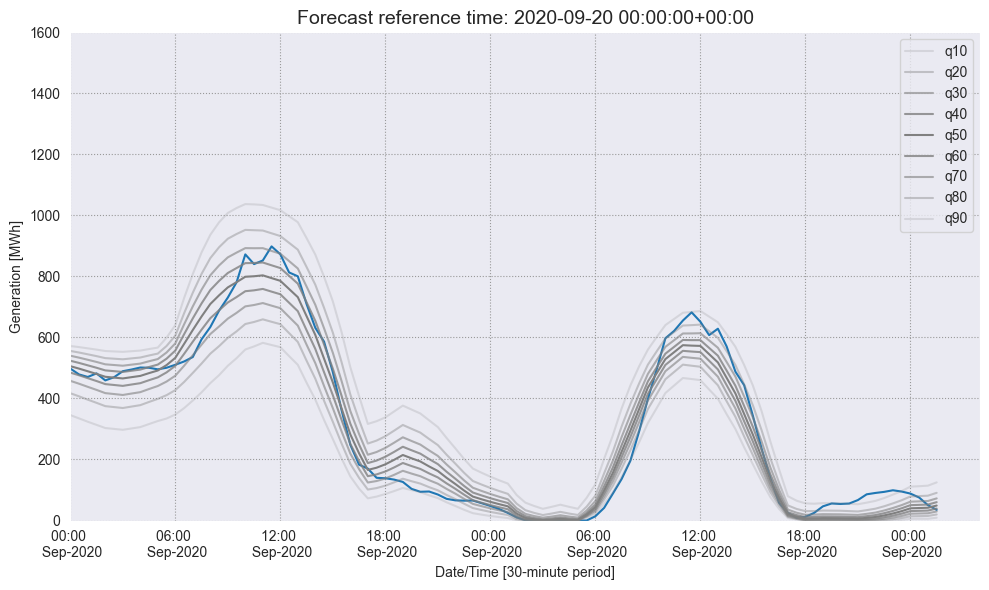

In [53]:
initial_data["total_generation_MWh"] = initial_data["Wind_MWh_credit"] + initial_data["Solar_MWh_credit"]
ref_time = initial_data["ref_datetime"] == initial_data["ref_datetime"][10]

plt.figure(figsize=(10,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=initial_data[ref_time], x="valid_datetime",
                   y="total_generation_MWh")

for quantile in range(10,100,10):
    sns.lineplot(data=initial_data,
                 x=initial_data[ref_time]["valid_datetime"],
                 y=initial_data[ref_time][f"q{quantile}"],
                 color='gray',
                 alpha=1-abs(50-quantile)/50,
                 label=f'q{quantile}')

plt.ylim(0, 1600)
plt.xlim(initial_data[ref_time]['valid_datetime'].min())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %b-%Y"))
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
plt.title(f"Forecast reference time: {initial_data[ref_time]['ref_datetime'][0]}",
          fontsize=14)
plt.tight_layout()

In [55]:
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

def pinball_score(data):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=data["total_generation_MWh"],
            q=data[f"q{qu}"],
            alpha=qu/100).mean())
    return sum(score)/len(score)

pinball_score(initial_data)

29.517309506174122

In [61]:
29.51707724748708-29.517309506174122

-0.00023225868704201957

/var/folders/sj/xlrs69b568n4mntwz_7crr4r0000gn/T/ipykernel_38249/1662070374.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forecast_performance = initial_data.groupby('lead_time').apply(pinball_score)


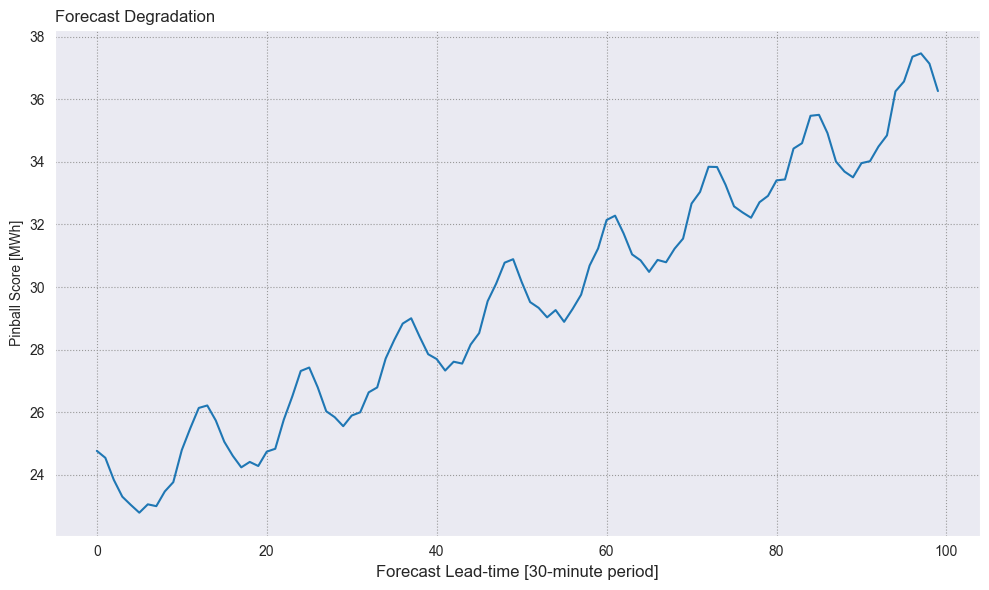

In [56]:
initial_data['lead_time'] = initial_data['valid_datetime'] - initial_data['ref_datetime']

forecast_performance = initial_data.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (1800)

plt.figure(figsize=(10,6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [30-minute period]', fontsize=12)
ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

In [59]:
import datetime
def day_ahead_market_times(today_date=pd.to_datetime('today')):

  tomorrow_date = today_date + pd.Timedelta(1,unit="day")
  DA_Market = [pd.Timestamp(datetime.datetime(today_date.year,today_date.month,today_date.day,23,0,0),
                          tz="Europe/London"),
              pd.Timestamp(datetime.datetime(tomorrow_date.year,tomorrow_date.month,tomorrow_date.day,22,30,0),
              tz="Europe/London")]

  DA_Market = pd.date_range(start=DA_Market[0], end=DA_Market[1],
                  freq=pd.Timedelta(30,unit="minute"))
  
  return DA_Market

def revenue(bid, y, day_ahead_price, single_system_price):
    return bid*day_ahead_price + (y-bid)*(single_system_price - 0.07*(y-bid))

submission_date = "2023-02-18"
submission_date_forecast = initial_data.loc[initial_data["ref_datetime"]==pd.to_datetime(submission_date,utc=True)]
market_day = pd.DataFrame({"datetime":day_ahead_market_times(today_date=pd.to_datetime(submission_date))})
market_day = market_day.merge(submission_date_forecast,how="left",left_on="datetime",right_on="valid_datetime")
market_day["market_bid"] = market_day["q50"]

revenue(bid=market_day["market_bid"],
        y=market_day["total_generation_MWh"],
        day_ahead_price=market_day["DA_Price"],
        single_system_price=market_day["SS_Price"]).sum()

2183451.440908499

In [60]:
2183451.131455035-2183451.440908499

-0.30945346411317587

In [66]:
# Next step
# 1) Create an Objective function (as a class)
# 2) Create an agent from Predictor and Optimizer classes
# 3) Create a validation dataset and run the agent 
# 4) (Optional) Create the energy system model 